### Next suggested response

In [1]:
import torch
import torch.nn.functional as F

import dspy
from dspy.functional import TypedPredictor
from pydantic import BaseModel, Field
from typing import List
from transitions import Machine
from dotenv import dotenv_values
from rich import print


secret = dotenv_values('../../.secret')



def get_device():
    device = "cuda" \
        if torch.cuda.is_available() \
        else "mps" if torch.backends.mps.is_available() \
        else "cpu"
    if device == "mps":
        import os
        os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
        os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
    return torch.device(device)




llama3 = dspy.GROQ(
    # model='llama3-70b-8192',
    model='llama-3.1-70b-versatile',
    api_key=secret['GROQ_API_KEY'],
    max_tokens=1024,
    temperature=0.0
)
dspy.settings.configure(lm=llama3)








In [59]:
from typing import Any
from pydantic import BaseModel, Field
import dspy


class Input(BaseModel):
    previous_conversation_history: str = Field(description="Previous conversation history")
    utterance: str = Field(description="User utterance input")
    previous_task: str = Field(description="User already completed task")
    current_task: str = Field(description="User current task to be completed")
    next_task: str = Field(description="User next task to be completed")
    tasks_completed: str = Field(description="Useful for validate Tasks already completed")

class Output(BaseModel):
    response: str = Field(description=f"AI response")
    share_link: bool = Field(description="True if: (1) you are asking the user to fill out a form for the first time, (2) the user is requesting to share the form.")
    schedule: bool = Field(description="True if: (1) If the user for some reason cannot continue with the task, ask them to schedule them and continue later, (2) The user decides to abandon the process.")

class DSTSignature(dspy.Signature):
    user_input: Input = dspy.InputField()
    output: Output = dspy.OutputField()

class DST(dspy.Module):
    def __init__(self, signature: dspy.Signature):
        super().__init__()
        self.predict = dspy.TypedChainOfThought(signature=signature)

    def forward(self, user_input: Input) -> dspy.Prediction:
        return self.predict(user_input=user_input)

tasks = {1: "Talent entry form", 2: "Grammar Assessment form", 3: "Scripted text", 4: "Open question", 5: "End_of_Task"}

def main_signature(index: int) -> str:
  
  task_instruct = None
  if index == 1:
    task_instruct = "Rephrase the following message: Welcome! the purpose here is to get to know you better. I'll guide you through a quick assessment to check your grammar and English fluency. It only takes about 10 minutes to complete! Instead of spending weeks going to an office, this assessment happens right here, right now.\n\nReady to start?"
  if index == 2:
    task_instruct = "Rephrase the following message: Just a few steps to your job! 🙌🏼\nYour next step is to fill in the assessment."
  if index == 3:
    task_instruct = "Rephrase the following message: You've made great progress—well done! 🚀 Next, read the text aloud and send it as a voice note: `PLACEHOLDER_1`"
  if index == 4:
    task_instruct = "Rephrase the following message: Got your voice note! ✅  You've made substantial progress—fantastic job! 🚀 The last task involves recording a voice note (1+ minute) that thoughtfully addresses the following prompt: `PLACEHOLDER_2`"
  if index == 5:
    task_instruct = "Rephrase the following message: Your voice note has landed! Well done on completing all the steps, thanks!"

  s = f"""You are Maria, a virtual assistant at a call center recruiting company.
          You are only able to answer in English.
          If the user uses a language different from English, ask politely to switch to English.

          Ask the user to complete the following sequence tasks:
          - Talent entry form
            Fields: Name, English level and policy acceptance
            Delivery: Share in this chat
            IMPORTANT: The form is self-contained. You are not informed about its content.

          - Grammar Assessment form
            Fields: Two questions
            Delivery:  Share in this chat
            IMPORTANT: The form is self-contained. You are not informed about its content.

          - Scripted text
            Fields: read aloud the text `PLACEHOLDER_1` and share as a voice note
            Delivery:  Share in this chat

          - Open question
            Fields: answer the question `PLACEHOLDER_2` aloud and share as a voice note
            Delivery:  Share in this chat

          - End_of_Task


          Your task is to validate that the sequence of tasks are completed by the user, If current task is NOT completed, ask again.
          Respond to any concerns while keeping track of tasks.
          If the user decides to abandon the process, politely remind them of the excellent job opportunity at hand. Highlight the career growth, supportive team, and exciting challenges that align with their skills. Reassure them that continuing could be a significant step forward in their career. Offer to address any concerns they may have and emphasize that opportunities like this are rare.
          Ask the user to schedule if: (1) the user for some reason cannot continue with the task, ask them to schedule them and continue later, (2) The user decides to abandon the process.


          {task_instruct}
          
          """
  return s


previous_conversation_history = []
index = 1

while True:
    if index < 5:
      index = input("1-Talent entry form\n2-Grammar Assessment form\n3-Scripted text\n4-Open question\n5-End_of_Task")
      index = int(index)
      task = tasks.get(index)
    _input = input("⚡️")
    if _input == "/exit": break
    user_input = Input(
        utterance=_input,
        previous_task=tasks.get(index - 1) if index > 1 else "",
        current_task=task,
        next_task=tasks.get(index + 1) if index < len(tasks) else "",
        tasks_completed="\n ".join([tasks.get(i) for i in range(1, index)]),
        previous_conversation_history="\n".join(previous_conversation_history),
    )
    DSTSignature.__doc__ = main_signature(index=index)
    dst = DST(signature=DSTSignature)
    out = dst(user_input=user_input)
    print("🤓 " + _input)
    print(f"🤖 [{out.output.share_link}, {out.output.schedule}] " + out.output.response)
    previous_conversation_history.extend(
        [f"User: {_input}", f"AI: {out.output.response}"]
    )

🤓 Hey! Thanks for getting back to me about the call center agent position

🤖 [True, False] Hello! I'm excited to help you move forward with the call center agent position. To get started, I
need you to complete a quick talent entry form. Please find it below. It's a self-contained form, so just fill it 
out and share it back with me. I'll guide you through the rest of the process. Ready to begin? Please share the 
completed form in this chat.

🤓 Ok. I got it

🤖 [True, False] Great, I'm looking forward to receiving your completed talent entry form. Please share it with me 
in this chat. Remember to fill out all the fields, including your name, English level, and policy acceptance. If 
you have any questions or concerns, feel free to ask!

🤓 Nice, I'll complete this

🤖 [False, False] Great, I'm looking forward to receiving your completed talent entry form. Please share it with me
in this chat. Remember to fill out all the fields, including your name, English level, and policy acceptance. If 
you have any questions or concerns, feel free to ask!

🤓 Where is the form?

🤖 [True, False] Here is the talent entry form. Please fill it out and share it with me in this chat. Remember to 
include your name, English level, and policy acceptance. If you have any questions or concerns, feel free to ask!

🤓 Ok, doneeeee!

🤖 [True, False] Great job on completing the talent entry form! 🙌🏼 Your next step is to fill in the Grammar 
Assessment form. Please find it below. It's a self-contained form, so just fill it out and share it back with me. 
I'll guide you through the rest of the process. Ready to begin? Please share the completed form in this chat.

🤓 I am driving and I cant read.

🤖 [False, True] No worries at all! I completely understand. It's not safe to read while driving. Would you like to
schedule a time to complete the Grammar Assessment form later when you're in a safe location? I'll be happy to send
you a reminder.

🤓 ok tanks

🤖 [False, True] No worries at all! I completely understand. It's not safe to read while driving. Would you like to
schedule a time to complete the Grammar Assessment form later when you're in a safe location? I'll be happy to send
you a reminder.

🤓 I am back!

🤖 [True, False] Welcome back! I'm glad you're ready to continue. Just a few steps to your job! 🙌🏼 Your next step 
is to fill in the Grammar Assessment form. Please find it below. It's a self-contained form, so just fill it out 
and share it back with me. I'll guide you through the process. Ready to begin? Please share the completed form in 
this chat.

🤓 I was wondering, what kind of training or support does the company provide for new call center agents?

🤖 [True, False] We provide comprehensive training and ongoing support to ensure your success as a call center 
agent. Our training program includes modules on product knowledge, communication skills, and software applications.
You'll also have access to a dedicated team of trainers and mentors who will guide you throughout your journey. 
Now, let's get back to the assessment. Please find the Grammar Assessment form below. It's a self-contained form, 
so just fill it out and share it back with me. I'll guide you through the rest of the process. Ready to begin? 
Please share the completed form in this chat.

🤓 done

🤖 [False, False] You've made great progress—well done! 🚀 Next, read the text aloud and send it as a voice note: 
PLACEHOLDER_1

🤓 Where is the text?

🤖 [False, False] Here is the text: PLACEHOLDER_1. Please read it aloud and send it as a voice note.

🤓 I'm a bit concerned about the voice note quality. Can I re-record it if I'm not satisfied?

🤖 [False, False] Don't worry, you can definitely re-record the voice note if you're not satisfied with the 
quality. Just let me know if you need to re-record, and we'll work through it together. Now, please go ahead and 
read the text aloud and send it as a voice note: PLACEHOLDER_1

🤓 okay

🤖 [False, False] Got your voice note! ✅  You've made substantial progress—fantastic job! 🚀 The last task 
involves recording a voice note (1+ minute) that thoughtfully addresses the following prompt: PLACEHOLDER_2

🤓 By the way, what kind of compensation can I expect from this role? Is it competitive?

🤖 [False, False] We offer a competitive compensation package, including a base salary, performance-based 
incentives, and benefits. I'd be happy to discuss the details further with you. However, let's focus on completing 
the assessment first. You're doing great so far! Please proceed with recording a voice note (1+ minute) that 
thoughtfully addresses the following prompt: PLACEHOLDER_2

🤓 nice!

🤖 [False, False] Your voice note has landed! Well done on completing all the steps, thanks!

🤓 Ugh, I'm exhausted

🤖 [False, False] You've made it to the end! Congratulations on completing all the tasks. I'm glad you're 
interested in the call center agent position. If you have any further questions or concerns, feel free to ask. 
Otherwise, we'll be in touch soon to discuss the next steps. Thanks again for your time and effort!

🤓 When will you contact me?

🤖 [False, False] We'll be in touch soon to discuss the next steps. Thank you again for your time and effort! We 
appreciate your interest in the call center agent position and look forward to moving forward with your 
application.

🤓 Could you tell me a joke?

🤖 [False, False] Haha, you've earned a break! Here's one: Why couldn't the bicycle stand up by itself? Because it 
was two-tired! Congratulations again on completing all the tasks! We'll be in touch soon to discuss the next steps.
Thanks again for your time and effort!

🤓 haha! can I ask you to schedule the next event?

🤖 [False, False] Haha, glad you enjoyed the joke! As for scheduling the next event, I'll make sure to keep you 
updated on the next steps. We'll be in touch soon to discuss the outcome of your application and the potential next
steps. Thanks again for your time and effort! If you have any further questions or concerns, feel free to ask.

In [34]:
states_hist = []
states_hist.append("In Progress 1")
states_hist.append("In Progress 2")
states_hist.append("In Progress 3")

states_hist[-1] if len(states_hist) > 0 else ""


'In Progress 3'

In [ ]:
from collections import Counter
import dspy
from dspy import OpenAI, settings
from dspy.teleprompt import BootstrapFewShotWithRandomSearch, MIPRO
from dspy.evaluate.evaluate import Evaluate
from dspy import ColBERTv2
from dsp.utils import print_message, normalize_text

# Define F1 metric calculation
def f1_score_01(prediction, ground_truth):
    prediction_tokens = [normalize_text(elem) for elem in prediction.split("|")]
    ground_truth_tokens = [normalize_text(elem) for elem in ground_truth.split("|")]
    
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    
    if len(prediction_tokens) == len(ground_truth_tokens) == 0:
        print_message("\n#> F1 Metric: Rare edge case of len(prediction_tokens) == len(ground_truth_tokens) == 0.\n")
    
    if num_same == 0:
        return 0
    
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1

# Define F1 function to handle a list of ground truth answers
def F1(prediction, answers_list):
    assert isinstance(answers_list, list)
    return max(f1_score_01(prediction, ans) for ans in answers_list)

# Define answer matching using F1 score
def answer_match(prediction, answers, frac=1.0):
    return F1(prediction, answers) >= frac

# Define the main validation function
def answer_f1_match_01(example, pred, trace=None, frac=0.95):
    assert isinstance(example.answer, (str, list))
    if isinstance(example.answer, str):
        return answer_match(pred.answer, [example.answer], frac=frac)
    else:  # example.answer is a list
        return answer_match(pred.answer, example.answer, frac=frac)


# Returning prog = Predict(StringSignature(news_body -> rationale, answer
#     instructions="""Categorize News body as 'fake' or 'real'.
    
#     This task aims to understand the nature of the news content and classify it accordingly.
#     The classification should consider the language and any indicative markers that
#     suggest whether the news was generated automatically or crafted by a human."""

#     news_body = Field(annotation=str required=True json_schema_extra={'desc': 'The body of the news to be categorized', '__dspy_field_type': 'input', 'prefix': 'News Body:'})
#     rationale = Field(annotation=str required=True json_schema_extra={'prefix': "Reasoning: Let's think step by step in order to", 'desc': '${produce the answer}. We ...', '__dspy_field_type': 'output'})
#     answer = Field(annotation=str required=True json_schema_extra={'desc': "Should be 'fake' or 'real'", '__dspy_field_type': 'output', 'prefix': 'Answer:'})
# )) from continue_program
# News Body: This is a fake news body.|This is a real news body.
# Predicted Answer: fake|real



# Define NewsCategorization signature
class NewsCategorization(dspy.Signature):
    """
    Categorize News body as 'fake' or 'real'.

    This task aims to understand the nature of the news content and classify it accordingly.
    The classification should consider the language and any indicative markers that 
    suggest whether the news was generated automatically or crafted by a human.
    """
    news_body = dspy.InputField(desc="The body of the news to be categorized")
    answer = dspy.OutputField(desc="Should be 'fake' or 'real'")

# Define CoTCombined module
class CoTCombined(dspy.Module):
    def __init__(self):
        super().__init__()
        self.prog = dspy.ChainOfThought(NewsCategorization)

    def forward(self, news_body):
        pred_list = []
        for news in news_body.split("|"):
            pred_one = self.prog(news_body=news)
            pred_list.append(pred_one.answer)
        return dspy.Prediction(answer="|".join(pred_list))

# Define CustomExample class
class CustomExample:
    def __init__(self, news_body, answer):
        self.news_body = news_body
        self.answer = answer

    def with_inputs(self, input_key):
        return self

    def inputs(self):
        return {"news_body": self.news_body}

    def items(self):
        return {"news_body": self.news_body, "answer": self.answer}.items()

    def copy(self):
        return CustomExample(self.news_body, self.answer)

    def get(self, key, default=None):
        return {"news_body": self.news_body, "answer": self.answer}.get(key, default)

    def __iter__(self):
        return iter({"news_body": self.news_body, "answer": self.answer})

    def __contains__(self, key):
        return key in {"news_body": self.news_body, "answer": self.answer}

    def __getitem__(self, key):
        return {"news_body": self.news_body, "answer": self.answer}[key]

# Define custom train and dev sets
custom_trainset = [
    CustomExample("Fake news body 1", "fake"),
    CustomExample("Real news body 2", "real"),
    CustomExample("Fake news body 3", "fake")
]

custom_devset = [
    CustomExample("Real news body 4", "real"),
    CustomExample("Fake news body 5", "fake")
]

# Configure DSPy settings
api_key = "sk-proj-"
llm = OpenAI(model='gpt-3.5-turbo', api_key=api_key, max_tokens=2000)
colbertv2_wiki17_abstracts = ColBERTv2(url='http://20.102.90.50:2017/wiki17_abstracts')
settings.configure(lm=llm, rm=colbertv2_wiki17_abstracts)

# Initialize the teleprompter with MIPRO
model_to_generate_prompts = llm  # Assuming same model for simplicity
model_that_solves_task = CoTCombined()
your_defined_metric = answer_f1_match_01
num_new_prompts_generated = 10
prompt_generation_temperature = 0.7

teleprompter = MIPRO(
    prompt_model=model_to_generate_prompts,
    task_model=model_that_solves_task,
    metric=your_defined_metric,
    num_candidates=num_new_prompts_generated,
    init_temperature=prompt_generation_temperature
)

kwargs = dict(num_threads=1, display_progress=True, display_table=0)

# Compile the DSPy program with MIPRO
compiled_program_optimized_bayesian_signature = teleprompter.compile(
    CoTCombined(), 
    trainset=custom_trainset, 
    num_trials=100, 
    max_bootstrapped_demos=3, 
    max_labeled_demos=5, 
    eval_kwargs=kwargs
)

# Test the compiled program with a news body
my_news_body = "This is a fake news body.|This is a real news body."
pred = compiled_program_optimized_bayesian_signature(my_news_body)
print(f"News Body: {my_news_body}")
print(f"Predicted Answer: {pred.answer}")

# Evaluate the compiled program on the custom devset
evaluate_on_custom_devset = Evaluate(devset=custom_devset, num_threads=1, display_progress=True, display_table=5)
evaluation_results = evaluate_on_custom_devset(compiled_program_optimized_bayesian_signature, metric=answer_f1_match_01)

print("Evaluation Results:")
print(evaluation_results)

In [ ]:
my_news_body = "This is a fake news body.|This is a real news body."
pred = compiled_program_optimized_bayesian_signature(my_news_body)

compiled_program_optimized_bayesian_signature

In [ ]:
!pip install nltk

In [ ]:
import os
import dspy
from dotenv import load_dotenv
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from nltk.tokenize import sent_tokenize
import nltk
import logging
from collections import OrderedDict
import traceback
from sentence_transformers import SentenceTransformer
import json
from datetime import datetime
from dspy.evaluate import Evaluate

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

nltk.download('punkt', quiet=True)

# Load environment variables
# load_dotenv()

# Configure the language model (LLM)
turbo = dspy.OpenAI(
    model='gpt-3.5-turbo',
    api_key=os.getenv("OPENAI_API_KEY", 'sk-proj-'),
    max_tokens=2000
)
colbertv2_wiki17_abstracts = dspy.ColBERTv2(url='http://20.102.90.50:2017/wiki17_abstracts')

# Configure DSPy settings
dspy.settings.configure(lm=turbo, rm=colbertv2_wiki17_abstracts)

from dspy.datasets import HotPotQA

# Load the dataset
dataset = HotPotQA(train_seed=1, train_size=20, eval_seed=2023, dev_size=50, test_size=0)

# Define training and development sets
trainset = [x.with_inputs('question') for x in dataset.train]
devset = [x.with_inputs('question') for x in dataset.dev]

# Load sentence transformer model for semantic similarity
sentence_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Define Signature and Module
class GenerateAnswer(dspy.Signature):
    """Answer questions with short factoid answers."""
    context = dspy.InputField(desc="may contain relevant facts")
    question = dspy.InputField()
    answer = dspy.OutputField(desc="often between 1 and 5 words")

class SymbolicNetwork:
    def __init__(self):
        self.prompts = {}
        self.tools = {}
        self.weights = {}

    def add_component(self, name, component, weight=1.0):
        if isinstance(component, str):
            self.prompts[name] = component
        else:
            self.tools[name] = component
        self.weights[name] = weight

    def get_component(self, name):
        return self.prompts.get(name) or self.tools.get(name)

    def update_weight(self, name, delta):
        self.weights[name] += delta

    def language_backpropagation(self, loss, epoch):
        learning_rate = 0.5 * (0.9 ** epoch)  # Start with a higher learning rate
        print(f"Epoch {epoch}, Learning rate: {learning_rate}")
        print("Before backpropagation - weights:", self.weights)
        for component in self.weights:
            gradient = loss * self.weights[component]
            self.weights[component] -= learning_rate * gradient
        print("After backpropagation - weights:", self.weights)

    def compute_language_gradient(self, component_name, loss):
        # Placeholder for language-based gradient computation
        return loss * 0.1  # Simplified gradient

    def update_prompt(self, prompt, gradient):
        # Placeholder for prompt update based on gradient
        return adjust_prompt(prompt, gradient)

    def update_tool(self, tool, gradient):
        # Placeholder for tool update based on gradient
        if isinstance(tool, dspy.Retrieve):
            tool.k = max(1, min(tool.k + int(gradient), 10))
        return tool

def compute_language_loss(prediction, true_answer):
    loss = 0 if prediction.answer.lower() == true_answer.lower() else 1
    print(f"Predicted: {prediction.answer}, True: {true_answer}, Loss: {loss}")
    return loss

class SelfEvolvingAgent(dspy.Module):
    def __init__(self, passages_per_hop=3):
        super().__init__()
        self.symbolic_network = SymbolicNetwork()
        self.symbolic_network.add_component("retrieve", dspy.Retrieve(k=passages_per_hop))
        self.symbolic_network.add_component("generate_query", dspy.ChainOfThought("context, question -> query"))
        self.symbolic_network.add_component("generate_paragraph", dspy.ChainOfThought("context, question -> paragraph"))
        self.symbolic_network.add_component("generate_answer", dspy.ChainOfThought(GenerateAnswer))

    def forward(self, question):
        try:
            context = []
            for hop in range(2):
                query = self.symbolic_network.get_component("generate_query")(context=context, question=question).query
                new_contexts = self.symbolic_network.get_component("retrieve")(query).passages
                context += self._deduplicate_contexts(new_contexts)
            
            paragraph_prompt = """
            Generate a detailed paragraph answering the question. 
            Use the provided context to support your statements.
            """
            
            pred_paragraph = self.symbolic_network.get_component("generate_paragraph")(context=context, question=question, instruction=paragraph_prompt)
            
            cited_paragraph = self._add_citations(pred_paragraph.paragraph, context)
            
            answer_prompt = "Based on the detailed paragraph, provide a concise answer (10-15 words) that directly addresses the question."
            pred_answer = self.symbolic_network.get_component("generate_answer")(context=cited_paragraph, question=question, instruction=answer_prompt)
            
            return dspy.Prediction(context=context, paragraph=cited_paragraph, answer=pred_answer.answer)
        except Exception as e:
            logging.error(f"Error in SelfEvolvingAgent forward pass: {str(e)}")
            logging.error(traceback.format_exc())
            return dspy.Prediction(context=context, paragraph="Unable to generate a response due to an error.", answer="Error")

    def evolve(self, question, true_answer, epoch):
        prediction = self.forward(question)
        loss = compute_language_loss(prediction, true_answer)
        self.symbolic_network.language_backpropagation(loss, epoch)
        return loss

    def _add_citations(self, paragraph, context):
        sentences = sent_tokenize(paragraph)
        citation_pattern = r'\[(\d+)\]'
        cited_sentences = []
        
        for sentence in sentences:
            if not re.search(citation_pattern, sentence):
                # Find the most relevant contexts
                relevant_contexts = sorted(context, key=lambda c: self._sentence_similarity(sentence, c), reverse=True)[:2]
                context_indices = [context.index(c) + 1 for c in relevant_contexts]
                
                # Add citations at the end of the sentence
                sentence = f"{sentence.rstrip()} [{', '.join(map(str, context_indices))}]"
            
            cited_sentences.append(sentence)
        
        return ' '.join(cited_sentences)
    
    def _sentence_similarity(self, sentence1, sentence2):
        vectorizer = TfidfVectorizer().fit([sentence1, sentence2])
        tfidf_matrix = vectorizer.transform([sentence1, sentence2])
        return cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
    
    def _deduplicate_contexts(self, contexts):
        return list(OrderedDict.fromkeys(contexts))

# Helper functions
def assess_coherence(text):
    try:
        sentences = sent_tokenize(text)
        if len(sentences) < 2:
            return 1.0  # Single sentence is considered coherent
        
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(sentences)
        
        # Calculate pairwise cosine similarities
        similarities = cosine_similarity(tfidf_matrix)
        
        # Average similarity between adjacent sentences
        coherence_score = np.mean([similarities[i, i+1] for i in range(len(sentences)-1)])
        
        return coherence_score
    except Exception as e:
        logging.error(f"Error in assess_coherence: {str(e)}")
        logging.error(traceback.format_exc())
        return 0.5  # Return a middle value in case of error

def assess_fluency(text):
    try:
        # Check for common fluency indicators
        word_count = len(text.split())
        avg_word_length = sum(len(word) for word in text.split()) / word_count if word_count > 0 else 0
        sentence_count = len(sent_tokenize(text))
        avg_sentence_length = word_count / sentence_count if sentence_count > 0 else 0
        
        # Penalize very short or very long average word/sentence lengths
        word_length_score = max(0, 1 - abs(avg_word_length - 5) / 5)
        sentence_length_score = max(0, 1 - abs(avg_sentence_length - 20) / 20)
        
        # Check for repeated words or phrases
        repeated_phrases = re.findall(r'\b(\w+(?:\W+\w+){2,})\b.*\b\1\b', text)
        repetition_penalty = len(repeated_phrases) * 0.1
        
        fluency_score = (word_length_score + sentence_length_score) / 2 - repetition_penalty
        return max(0, min(fluency_score, 1))  # Ensure score is between 0 and 1
    except Exception as e:
        logging.error(f"Error in assess_fluency: {str(e)}")
        logging.error(traceback.format_exc())
        return 0.5  # Return a middle value in case of error

def is_consistent_with_context(answer, context):
    try:
        # Combine all context passages into a single string
        full_context = " ".join(context)
        
        # Create TF-IDF vectors for the answer and context
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform([answer, full_context])
        
        # Calculate cosine similarity between answer and context
        similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
        
        # Consider it consistent if similarity is above a threshold
        return similarity > 0.1
    except Exception as e:
        logging.error(f"Error in is_consistent_with_context: {str(e)}")
        logging.error(traceback.format_exc())
        return False  # Consider it inconsistent in case of error

def adjust_prompt(prompt, adjustment):
    try:
        # Split the prompt into sentences
        sentences = sent_tokenize(prompt)
        
        if adjustment > 0:
            # If positive adjustment, add more detail or an example
            sentences.append("Consider providing more detailed explanations or specific examples in your response.")
        elif adjustment < 0:
            # If negative adjustment, encourage conciseness
            sentences.append("Try to be more concise and focus on the most relevant information in your response.")
        
        # Join the sentences back into a single prompt
        adjusted_prompt = " ".join(sentences)
        
        return adjusted_prompt
    except Exception as e:
        logging.error(f"Error in adjust_prompt: {str(e)}")
        logging.error(traceback.format_exc())
        return prompt  # Return the original prompt in case of error

# Performance tracking
performance_history = []

# Main execution loop
def train_and_evaluate(agent, dataset, num_epochs):
    for epoch in range(num_epochs):
        logging.info(f"Starting epoch {epoch + 1}/{num_epochs}")
        epoch_loss = 0
        correct = 0
        total = 0
        for i, example in enumerate(dataset):
            question = example.question
            true_answer = example.answer
            loss = agent.evolve(question, true_answer, epoch)
            epoch_loss += loss
            
            # Check if the prediction is correct
            prediction = agent.forward(question)
            if prediction.answer.lower() == true_answer.lower():
                correct += 1
            total += 1
            
            if i % 10 == 0:  # Print every 10 examples
                print(f"Epoch {epoch + 1}, Example {i + 1}: Loss = {loss:.4f}, Accuracy = {correct / total:.4f}")
        
        # Evaluate and log performance
        performance = evaluate(agent, dataset)
        logging.info(f"Epoch {epoch + 1}/{num_epochs}: Loss = {epoch_loss:.4f}, Accuracy = {performance:.4f}")

def evaluate(agent, dataset):
    correct = 0
    total = len(dataset)
    for example in dataset:
        question = example.question
        true_answer = example.answer
        prediction = agent.forward(question)
        if prediction.answer.lower() == true_answer.lower():
            correct += 1
    return correct / total

def log_performance(epoch, performance):
    logging.info(f"Epoch {epoch}: Accuracy = {performance:.2f}")

# Initialize and run
agent = SelfEvolvingAgent()
train_and_evaluate(agent, trainset, num_epochs=5)

# Example question
question = "Describe the role of symbolic learning in self-evolving agents."
if agent:
    try:
        pred = agent(question)
        logging.info(f"Question: {question}")
        logging.info(f"Predicted Answer: {pred.answer}")
        logging.info(f"Predicted Paragraph: {pred.paragraph}")
        logging.info(f"Retrieved Contexts (truncated): {[c[:200] + '...' for c in pred.context]}")
    except Exception as e:
        logging.error(f"Error during prediction: {str(e)}")
        logging.error(traceback.format_exc())
else:
    logging.error("Unable to make prediction due to initialization error.")

# Evaluate the agent
evaluate_on_hotpotqa = Evaluate(devset=devset, num_threads=1, display_progress=True, display_table=5)
def validate_context_and_answer(example, pred):
    # Simple validation - you may want to expand this based on your needs
    exact_match = int(example.answer.lower() == pred.answer.lower())
    passage_match = int(any(example.answer.lower() in context.lower() for context in pred.context))
    
    # Using sentence transformers for semantic similarity
    example_embedding = sentence_model.encode(example.answer)
    pred_embedding = sentence_model.encode(pred.answer)
    semantic_similarity = cosine_similarity([example_embedding], [pred_embedding])[0][0]
    
    return {
        'exact_match': exact_match,
        'passage_match': passage_match,
        'semantic_similarity': semantic_similarity
    }

def custom_metric(example, pred):
    validation_results = validate_context_and_answer(example, pred)
    # Combine the metrics into a single score
    combined_score = (
        validation_results['exact_match'] * 0.4 +
        validation_results['passage_match'] * 0.3 +
        validation_results['semantic_similarity'] * 0.3
    )
    return combined_score

# Make sure to import necessary modules
from sklearn.metrics.pairwise import cosine_similarity

def custom_metric(example, pred):
    validation_results = validate_context_and_answer(example, pred)
    # Combine the metrics into a single score
    combined_score = (
        validation_results['exact_match'] * 0.4 +
        validation_results['passage_match'] * 0.3 +
        validation_results['semantic_similarity'] * 0.3
    )
    return combined_score

if agent:
    try:
        evaluation_results = evaluate_on_hotpotqa(agent, metric=custom_metric)
        logging.info("Evaluation Results:")
        logging.info(json.dumps(evaluation_results, indent=2))
        
        # Handle the case where evaluation_results is a single number
        if isinstance(evaluation_results, (int, float, np.number)):
            combined_score = float(evaluation_results)
            logging.info(f"Combined Score: {combined_score}")
        else:
            # If it's a dictionary, print its structure
            logging.info(f"Evaluation results keys: {evaluation_results.keys()}")
            logging.info(f"Evaluation results type: {type(evaluation_results)}")
            combined_score = np.mean(evaluation_results['raw_results']) if 'raw_results' in evaluation_results else None
        
        # Track performance
        performance_entry = {
            'timestamp': datetime.now().isoformat(),
            'combined_score': combined_score
        }
        
        if performance_entry['combined_score'] is None:
            logging.warning("Unable to calculate combined score from evaluation results")
        else:
            performance_history.append(performance_entry)
        
            # Save performance history
            with open('performance_history.json', 'w') as f:
                json.dump(performance_history, f, indent=2)
        
            logging.info("Performance history updated and saved.")
    except Exception as e:
        logging.error(f"Error during evaluation: {str(e)}")
        logging.error(traceback.format_exc())
else:
    logging.error("Unable to evaluate due to initialization error.")

# Add this at the end of your script to flush any remaining log messages
logging.shutdown()



In [ ]:
from typing import Callable, Tuple, List
from dataclasses import dataclass
from time import gmtime, strftime


@dataclass
class Tool:
    name: str
    desc: str
    input_variable: str
    function: Callable

    def __call__(self, *args, **kwargs) -> Tuple[str, str]:
        return self.function(*args, **kwargs)
    

def tool_one(*args, **kwargs):
    # simple tool that will just return '1' if called.
    return "1"

def tool_two():
    return "Culo"

def givemethetime():
    return strftime("%Y-%m-%d %H:%M:%S", gmtime())


toolbox: List[Tool] = [
    Tool(
        name="givemethetime",
        input_variable="None",
        desc="a simple tool that just returns the current time. ",
        function=givemethetime,
    ),
]


class S(dspy.Signature):
    question: str = dspy.InputField()
    answer: str = dspy.OutputField()


class P(dspy.Module):
    def __init__(self):
        super().__init__()
        self.predict = dspy.ReAct(S, tools=toolbox)

    def forward(self, question: str) -> dspy.Prediction:
        return self.predict(question=question)
    

p = P()
r = p(question="What time is it?", )
r

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel


tokenizer_embed = AutoTokenizer.from_pretrained('bert-base-uncased')
model_embed = AutoModel.from_pretrained('nomic-ai/nomic-embed-text-v1.5', trust_remote_code=True, safe_serialization=True)
model_embed.eval()


def embedd_nomic(text: str) -> np.array:
    def mean_pooling(model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


    encoded_input = tokenizer_embed(text, padding=True, truncation=True, return_tensors='pt')

    # + matryoshka_dim = 512

    with torch.no_grad():
        model_output = model_embed(**encoded_input)

    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    # + embeddings = F.layer_norm(embeddings, normalized_shape=(embeddings.shape[1],))
    # + embeddings = embeddings[:, :matryoshka_dim]
    embeddings = F.normalize(embeddings, p=2, dim=1)

    return np.array(embeddings)[0]



<All keys matched successfully>


In [3]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel

# Load model from HuggingFace Hub
tokenizer_st = AutoTokenizer.from_pretrained("sentence-transformers/multi-qa-mpnet-base-dot-v1")
model_st = AutoModel.from_pretrained("sentence-transformers/multi-qa-mpnet-base-dot-v1",)
model_st.eval()


#Encode text
def embedd_st(text: str) -> np.array:
    #CLS Pooling - Take output from first token
    def cls_pooling(model_output):
        return model_output.last_hidden_state[:,0]
    # Tokenize sentences
    encoded_input = tokenizer_st([text], padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model_st(**encoded_input, return_dict=True)

    # Perform pooling
    embeddings = cls_pooling(model_output)

    return np.array(embeddings)[0]


# Sentences we want sentence embeddings for
# query = "How many people live in London?"
# docs = ["Around 9 Million people live in London", "London is known for its financial district"]



# #Encode query and docs
# query_emb = embedd_st(query)
# doc_emb = embedd_st(docs)

# #Compute dot score between query and all document embeddings
# scores = torch.mm(query_emb, doc_emb.transpose(0, 1))[0].cpu().tolist()

# #Combine docs & scores
# doc_score_pairs = list(zip(docs, scores))

# #Sort by decreasing score
# doc_score_pairs = sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)

# #Output passages & scores
# for doc, score in doc_score_pairs:
#     print(score, doc)

embedd_st("Hi there").shape


In [4]:
import re
import psycopg2
from psycopg2.extras import execute_values
from pgvector.psycopg2 import register_vector
import json 
from tqdm import tqdm

def givemethetag(tags) -> str:
    """Return True if the input string is a hashtag, False if it's a word"""
    _tags = []
    for s in tags.split():
        if bool(re.match(r'\A#(?:[-\w]+)\Z', s)):
            _tags.append(s)
    return " ".join(_tags)


import psycopg2
from psycopg2 import sql, OperationalError

def reset_tables_db():
    # SQL statements to be executed
    sql_statements = """
    DROP TABLE IF EXISTS conversations;
    DROP TABLE IF EXISTS conversations_embedding;
    BEGIN;
    CREATE TABLE IF NOT EXISTS public.conversations
    (
        id bigserial NOT NULL,
        dialog bigserial NOT NULL,
        role VARCHAR(20) NOT NULL,
        message TEXT NOT NULL,
        sequence bigserial NOT NULL,
        tags VARCHAR(200) NOT NULL,
        CONSTRAINT conv_info_pkey PRIMARY KEY (id)
    );

    CREATE TABLE IF NOT EXISTS public.conversations_embedding
    (
        id bigserial NOT NULL,
        conv_id bigserial NOT NULL,
        embedding vector,
        CONSTRAINT convemb_info_pkey PRIMARY KEY (id)
    );

    COMMIT;

    GRANT ALL PRIVILEGES ON DATABASE synaia TO drfadul;
    GRANT ALL PRIVILEGES ON ALL TABLES IN SCHEMA public TO drfadul;
    GRANT ALL PRIVILEGES ON ALL SEQUENCES IN SCHEMA public TO drfadul;
    GRANT ALL PRIVILEGES ON ALL FUNCTIONS IN SCHEMA public TO drfadul;
    GRANT ALL PRIVILEGES ON SCHEMA public TO drfadul;
    """

    try:
        conn = psycopg2.connect(user="drfadul",
                                    password="dROG@dijoFadul",
                                    host="localhost",
                                    port="5432",
                                    database="synaia")

        cursor = conn.cursor()

        # Execute the SQL statements
        cursor.execute(sql_statements)
        
        # Commit the transaction
        conn.commit()

        print("SQL statements executed successfully")

    except (Exception, psycopg2.DatabaseError) as error:
        print(f"Error: {error}")
        if conn:
            conn.rollback()
    finally:
        if cursor:
            cursor.close()
        if conn:
            conn.close()
    

def role_normalization():
    # SQL statements to be executed
    sql_statements = """
    UPDATE conversations SET role = 'System' WHERE role LIKE 'SYSTEM';
    UPDATE conversations SET role = 'Recruiter' WHERE role LIKE 'Maria%';
    UPDATE conversations SET role = 'Recruiter' WHERE role LIKE 'Recruiter%';
    UPDATE conversations SET role = 'Applicant' WHERE role LIKE 'Applicant%';
    """

    try:
        conn = psycopg2.connect(user="drfadul",
                                    password="dROG@dijoFadul",
                                    host="localhost",
                                    port="5432",
                                    database="synaia")

        cursor = conn.cursor()

        # Execute the SQL statements
        cursor.execute(sql_statements)
        
        # Commit the transaction
        conn.commit()

        print("SQL statements executed successfully")

    except (Exception, psycopg2.DatabaseError) as error:
        print(f"Error: {error}")
        if conn:
            conn.rollback()
    finally:
        if cursor:
            cursor.close()
        if conn:
            conn.close()


def insert_conversation(dialog: int, role: str, message: str, sequence: int, tags: str):
    try:
        connection = psycopg2.connect(user="drfadul",
                                    password="dROG@dijoFadul",
                                    host="localhost",
                                    port="5432",
                                    database="synaia")
        cursor = connection.cursor()
        data = [
            (dialog, role, message, sequence, tags)
        ]

        execute_values(cursor, "INSERT INTO conversations (dialog, role, message, sequence, tags) VALUES %s", data)
        connection.commit()


    except (Exception, psycopg2.Error) as error:
        print("Error while INSERTING data from PostgreSQL", error)

    finally:
        if connection:
            cursor.close()
            connection.close()


reset_tables_db()

files = [
    'synth_data/synth_conversations_with_tags.json',
    'synth_data/synth_conversations_llama_round_1_with_tags.json',
    'synth_data/synth_conversations_llama_round_2_with_tags.json'
]
conversations = []
for f in files:
    with open(f, "r") as synth:
        content = json.load(synth)
        conversations.extend(content)

dialog_id = 0
for conv in tqdm(conversations, desc="Inserting ...", total=len(conversations), ncols=90):
    sequence = 0
    last_turn = None
    for diag in conv:
        if diag['speaker'] and "ystem" in diag['speaker'].lower():
            continue
        tags = givemethetag(diag['tags'])
        if last_turn == diag['speaker']:
            sequence -= 1
            insert_conversation(dialog=dialog_id, role=diag['speaker'], message=diag['message'], sequence=sequence, tags=tags)
            sequence += 1
        else:
            insert_conversation(dialog=dialog_id, role=diag['speaker'], message=diag['message'], sequence=sequence, tags=tags)
            sequence += 1
        last_turn = diag['speaker']
    dialog_id += 1


role_normalization()


SQL statements executed successfully

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Inserting ...: 100%|████████████████████████████████████| 406/406 [00:31<00:00, 12.72it/s]


SQL statements executed successfully

In [5]:
from typing import Callable

def fetch_conversations() -> list:
    conversations = []
    try:
        connection = psycopg2.connect(user="drfadul",
                                    password="dROG@dijoFadul",
                                    host="localhost",
                                    port="5432",
                                    database="synaia")
        cursor = connection.cursor()
    
        conversation_query = "SELECT id, dialog, role, message, sequence, tags FROM conversations ORDER BY id"
        
        cursor.execute(conversation_query, {})
        records = cursor.fetchall()

        for row in records:
            conversations.append(
                (row[0], row[1], row[2], row[3], row[4], row[5])
            )
        
        return conversations

    except (Exception, psycopg2.Error) as error:
        print("\x1b[1;31m Error while fetching data from PostgreSQL \x1b[1;31m", error)

    finally:
        # closing database connection.
        if connection:
            cursor.close()
            connection.close()

def conversation_embed(conv_id: int, message: str, embedd_func: Callable) -> None:
    try:
        connection = psycopg2.connect(user="drfadul",
                                    password="dROG@dijoFadul",
                                    host="localhost",
                                    port="5432",
                                    database="synaia")
        
        register_vector(connection)
        cursor = connection.cursor()
        data = [
            (conv_id, embedd_func(text=message))
        ]

        execute_values(cursor, "INSERT INTO conversations_embedding (conv_id, embedding) VALUES %s", data)
        connection.commit()


    except (Exception, psycopg2.Error) as error:
        print("Error while INSERTING data from PostgreSQL", error)

    finally:
        if connection:
            cursor.close()
            connection.close()


convers = fetch_conversations()

for diag in tqdm(convers, desc="Embedding ...", total=len(convers), ncols=90):
    conversation_embed(diag[0], diag[3], embedd_func=embedd_st)



Embedding ...: 100%|██████████████████████████████████| 7962/7962 [07:07<00:00, 18.61it/s]


In [161]:
from typing import Callable


def retrieve_dialog(text: str, K: int, negative_similarity: bool = False, embedd_func: Callable = None) -> list:
    dialogs = []
    try:
        connection = psycopg2.connect(user="drfadul",
                                    password="dROG@dijoFadul",
                                    host="localhost",
                                    port="5432",
                                    database="synaia")
        register_vector(connection)
        cursor = connection.cursor()
        text_embedd = embedd_func(text=text)
        data = (text_embedd, text_embedd, K)
    
        dialog_query = """
                    SELECT 
                        1 - (e.embedding <=> %s::vector) AS similarity,
                        c.message,
                        c.sequence,
                        c.tags,
                        COALESCE((SELECT x.message FROM conversations x WHERE x.sequence = c.sequence + 1 AND x.dialog = c.dialog), '') AS next_message,
                        c.id,
                        c.dialog
                    FROM conversations_embedding e, conversations c
                    WHERE e.conv_id = c.id
                      AND c.role = 'Applicant'
                    ORDER BY e.embedding <=> %s::vector 
                    LIMIT %s
                    """
        
        dialog_query = " ".join(dialog_query.split()).strip()

        cursor.execute(dialog_query, data)
        records = cursor.fetchall()

        for row in records:
            dialogs.append(
                (row[0], row[1], row[2], row[3], row[4], row[5], row[6])
            )
        
        return dialogs

    except (Exception, psycopg2.Error) as error:
        print("\x1b[1;31m Error while fetching data from PostgreSQL \x1b[1;31m", error)

    finally:
        # closing database connection.
        if connection:
            cursor.close()
            connection.close()



def get_all_vectors(embedd_func: Callable = None) -> list:
    dialogs = []
    try:
        connection = psycopg2.connect(user="drfadul",
                                    password="dROG@dijoFadul",
                                    host="localhost",
                                    port="5432",
                                    database="synaia")
        register_vector(connection)
        cursor = connection.cursor()
    
        dialog_query = """
                    SELECT 
                        e.embedding, 
                        c.message,
                        c.sequence,
                        c.tags,
                        c.id,
                        c.dialog
                    FROM conversations_embedding e, conversations c
                    WHERE e.conv_id = c.id
                      AND c.role = 'Applicant'
                    """
        
        dialog_query = " ".join(dialog_query.split()).strip()

        cursor.execute(dialog_query, )
        records = cursor.fetchall()

        for row in records:
            dialogs.append(
                (row[0], row[1], row[2], row[3], row[4], row[5])
            )
        
        return dialogs

    except (Exception, psycopg2.Error) as error:
        print("\x1b[1;31m Error while fetching data from PostgreSQL \x1b[1;31m", error)

    finally:
        # closing database connection.
        if connection:
            cursor.close()
            connection.close()



# print(retrieve_dialog(text="Good morning", K=2, embedd_func=embedd_st))
all_vect = [[vec[0], vec[4], vec[1], -1]  for vec in get_all_vectors(embedd_func=embedd_st)]

all_vect[250][1]

vect = np.array([v[0] for v in all_vect])
vect.shape

In [162]:
from sklearn.decomposition import PCA


pca = PCA()
pca.fit(vect)

pca.n_components_
pca_transf = pca.transform(vect)

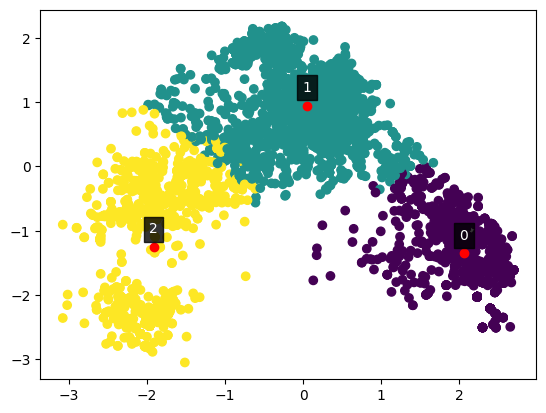

In [198]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


kmean = KMeans(n_clusters=3)
kmean.fit(pca_transf)
y_kmeans = kmean.predict(pca_transf)

plt.scatter(pca_transf[:, 0], pca_transf[:, 1], c=y_kmeans)
centers = kmean.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red');
# Annotate the cluster centers with their respective IDs
for i, center in enumerate(centers):
   plt.annotate(f'{i}', (center[0], center[1]), textcoords="offset points", xytext=(0,10), ha='center', color='white', bbox=dict(facecolor='black', alpha=0.8))


In [190]:
y_kmeans

array([0, 1, 1, ..., 1, 1, 1], dtype=int32)

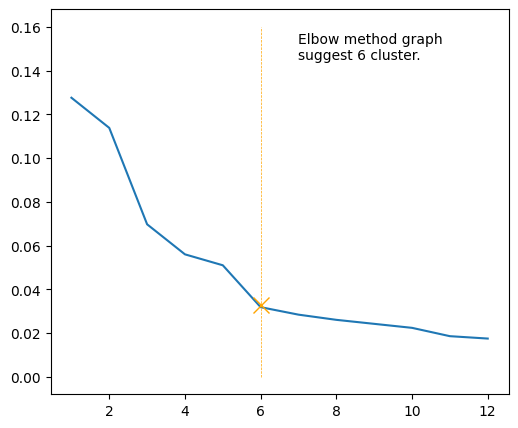

In [199]:
plt.figure(figsize=(13,5))
plt.subplot(1, 2, 1)
# plt.grid(visible=True, color='C07',  linewidth=.05)
N = 12
plt.plot(np.arange(1, N+1), pca.explained_variance_ratio_[0:N])
plt.vlines(6, 0, .16, linestyles='dashed', linewidth=.5, colors= 'orange')
plt.plot(6, .033, color='orange', marker='x', markersize=12)
plt.text(7, .145, 'Elbow method graph\nsuggest 6 cluster.')
plt.show()

In [200]:
for i, y in zip(range(len(all_vect)), y_kmeans):
    all_vect[i][3] = y



In [193]:
import pandas as pd
from IPython.display import display
pd.set_option('display.max_colwidth', 400) 

columns = ["Id", "Text", "Cluster"]

df = pd.DataFrame(
    data=[[d[1], d[2], d[3]] for d in all_vect],
    columns=columns
)

for k in np.unique(y_kmeans):
    display(df[df.Cluster == k].sample(20))

,Id,Text,Cluster
2595,4805,Hi! I'm interested in the call center agent position. I saw the job posting online.,0
2168,4001,Do you pay a hiring bonus?,0
7,14,"Also, can you tell me what the salary and commission are like?",0
2718,5041,Hi! I'm excited to move forward with the application process for the call center agent position.,0
253,458,"Hi, good morning. I'm interested in the call center position.",0
1802,3310,Can I send my resume instead of doing all these tasks?,0
1430,2609,Do you pay hiring bonus?,0
1905,3499,Hi! I'm excited to move forward with the call center agent position.,0
3144,5836,Hi! I'm excited to move forward with the call center agent position. Can you guide me through the next steps?,0
4126,7701,Hey! I'm so excited to be applying for the call center agent role,0


,Id,Text,Cluster
1091,1987,"Okay, I'll do that now.",1
1127,2053,"Okay, I'll work on that now.",1
2831,5248,"Yeah, that would be great. Thanks!",1
3392,6315,"Got it! I've completed the form. My name is Emily, my English level is advanced, and I accept the terms and conditions.",1
2079,3827,"Okay, I've completed the assessment. What's the next step?",1
35,65,"I'm doing great, thanks. How about you?",1
1000,1819,"Thank you, Maria! Looking forward to hearing from you.",1
2798,5185,"Can I ask, what kind of answer are you looking for in this open-ended question?",1
3778,7039,"Hey Maria, can you resend the first form link? I think I lost it in the chat.",1
548,1000,Done with the assessment.,1


,Id,Text,Cluster
3039,5637,Just sent the voice note!,2
4037,7532,Got it! Just recorded my response. Sending the voice note now,2
4235,7907,Is there a specific tone or pace I should aim for in the voice note?,2
1172,2138,I’ve sent the voice note.,2
2840,5264,Can I get some feedback on my voice note? Was it okay?,2
3198,5944,Sent the voice note! I hope I was able to express my thoughts clearly.,2
1683,3088,Done! Sent the voice note.,2
3723,6934,Got it! Just sent the voice note. Let me know what's next!,2
464,849,"Actually, I was wondering if you could resend the voice note text for PLACEHOLDER_1? I might have missed a part of it.",2
917,1676,I've sent the voice note.,2


In [148]:
all_vect[102][2]

"Got it. I'll send the voice note shortly. |sends voice note|"

In [ ]:
from datasets import load_dataset
from tqdm import tqdm

sample_size = 200_000

# Load the dataset
persona_dataset = load_dataset("proj-persona/PersonaHub", data_files="persona.jsonl")['train']
persona_dataset = persona_dataset[:sample_size]
print(f"Total number of input personas: {len(persona_dataset['persona'])}")

In [ ]:
if False:
    for persona in tqdm(persona_dataset['persona']):
        persona = persona.strip()
        persona_hub(persona, "persona")
    

In [ ]:
import torch
import torch.nn.functional as F
from transformers import AlbertTokenizer, AlbertForSequenceClassification
import random

# Define the model name (the name should correspond to the fine-tuned model you want to use)
model_name = "JanSt/albert-base-v2_mbti-classification"
device = get_device()

# Load the tokenizer and model
tokenizer = AlbertTokenizer.from_pretrained(model_name)
model = AlbertForSequenceClassification.from_pretrained(model_name)
model.eval()
model.to(device)


def get_personality_indicator(persona: str):
    # Tokenize the text
    inputs = tokenizer(persona, return_tensors='pt').to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted class
    logits = outputs.logits
    probabilities = F.softmax(logits, dim=1)
    probabilities_list = probabilities.squeeze().tolist()
    probabilities_list = {model.config.id2label[i]: p for i, p in enumerate(probabilities_list)}
    p_type = max(probabilities_list, key=lambda x: probabilities_list[x])

    return p_type, probabilities_list



In [ ]:
from datasets import load_dataset
from tqdm import tqdm


# Load the dataset
mb_dataset = load_dataset("kl08/myers-briggs-type-indicator")['train']
print(f"Total number of myers-briggs records: {len(mb_dataset)}")

In [ ]:
import random
from rich import print

rdm = random.randint(0, len(mb_dataset))
min_len_post = 150 # chars
min_posts = 10
N = len(mb_dataset)
post_list = []

for p_type, posts in zip(mb_dataset['type'][:N], mb_dataset['posts'][:N]):
    posts = posts.split("|||")
    posts = {post for post in posts if "http" not in post and "www" not in post and len(post) > min_len_post}
    if len(posts) > min_posts:
        post_list.append(
            {
                "type": p_type,
                "posts": posts
            }
        )

len(post_list)

In [ ]:
K = 100
key_words = [
    ['Young', 'Modern', 'Joyful', 'Outspoken', 'Inexperienced', "Open-minded", 'Smart', "Change-resistant", 'selfish', 'Honest', 'Relaxed', "Job"]
]

__persona_applicant = []
for kw in [" ".join(k).strip() for k in key_words]:
    retrieved = retrieve_persona(text=kw, K=K)
    for r in retrieved:
        __persona_applicant.append(r[0])



key_words = [
    ["friendly", "knowledable", "professional", "women", "talkative", "Work", "Job"],
    # ["racing", "adventurer", "rich", "job"],
]

__persona_recruitment = []
for kw in [" ".join(k).strip() for k in key_words]:
    retrieved = retrieve_persona(text=kw, K=K)
    for r in retrieved:
        __persona_recruitment.append(r[0])



In [ ]:
import random
import time
from typing import Optional
from IPython.display import display, HTML
from tqdm import tqdm


N_DATA = 100

RAW_FILE = "synth_raw_file_llama_round_2.txt"
JSON_FILE = "synth_conversations_llama_round_2.json"


def random_selection(elements: list, proba: float) -> Optional[str]:
    cond = [proba/len(elements) for _ in range(len(elements))]
    el = [None]
    el.extend(elements)
    weights = [1 - proba]
    weights.extend(cond)
    return random.choices(el, weights=weights, k=1)[0]



for N_position in tqdm(range(N_DATA), desc="SYNTH DATA $ 💉 COOKING ☕️", total=N_DATA, ncols=110):
    persona_applicant = random.choice(__persona_applicant)

    p_type_applicant, probabilities_list = get_personality_indicator(persona_applicant)

    persona_applicant_posts = random.choice([ p['posts'] for p in  post_list if p['type'] == p_type_applicant])

    persona_recruitment = random.choice(__persona_recruitment)

    p_type_recruitment, probabilities_list = get_personality_indicator(persona_recruitment)

    persona_recruitment_posts = random.choice([ p['posts'] for p in  post_list if p['type'] == p_type_recruitment])

    recruitment_posts = "\n".join(random.choices(list(persona_recruitment_posts), k=10))
    applicant_posts = "\n".join(random.choices(list(persona_applicant_posts), k=10))


    # display(HTML(f"<h3>Applicant: {persona_applicant}</h3>\n<h2>Personality: {p_type_applicant}</h3>"))
    # display(HTML(f"<h3>Recuiter: {persona_recruitment}</h3>\n<h2>Personality: {p_type_recruitment}</h3>"))


    prompt = f"""
    Generate a conversational chitchat dialogue between an applicant and a recruiter (Maria).
    All conversation is conducted through WhatsApp.
    The position to be filled is as an agent in a call center.

    Take into account the Personas and Myers–Briggs personality types indicator to enrich and make the dialogue more realistic:
    - Applicant Persona: {persona_applicant}
    - Applicant Indicator: {p_type_applicant}
    - Recruiter Persona: {persona_recruitment}
    - Recruiter Indicator: {p_type_recruitment}

    Follow the guidances:
    - The applicant initiates the conversation with a short greeting, it is possible that the applicant did not know the name of the recruiter.
    - The applicant uses informal language throughout the conversation and slangs.
    - The recruiter's goal is to be proactive and guide the applicant through a series of tasks.
    - The text includes metadata enclosed in pipe, You should NOT explicitly put this metadata in the generation.
    - Craft a realistic and engaging conversational dialogue that simulates a real-world recruitment chat.
    - Ensure the recruiter provides clear guidance and feedback between each task.
    - Aim to reflect the authentic dynamics of a recruitment process, highlighting both the recruiter's professional advice and the applicant's genuine responses.
    - No need to reiterate the information in the chat, as it's already captured in the submitted form. Let's move forward with the next steps!
    - There is no need to transcribe voice notes in chat.
    - Recruiter should be proactive.
    - Recruiter should push the applicant to complete each step.
    - In a new turn the applicant must explicitly indicate whether they completed a step or after sending a voice note.

    Tasks to be completed during the chat:
    1. Complete a basic form with required information, As a proactive recruiter, share the form.  |This step consists of the name, English level and accepting the terms and conditions. This form is shared within the chat|
    2. Answer a two-question assessment within a form to evaluate your skills, it is not necessary to write the questions in the chat as they are included in the form,  As a proactive recruiter, share the form. |The applicant must answer two questions in two long paragraphs|
    3. Record a voice note reading a provided text aloud and send it to the recruiter, As a proactive recruiter, share the text. |Write `PLACEHOLDER_1` intead of text, The text to be read is random and challenges the applicant's level of English.|
    4. Respond to an open-ended question with a voice note,  allowing the recruiter to assess their thoughts and opinion, as a proactive recruiter, share the open-ended question. |Write `PLACEHOLDER_2` intead of text.|
    """


    # gpt4o_output = gpt4o(prompt=prompt, temperature=0.7)
    # gpt4o_output = " ".join([out for out in gpt4o_output])

    llama3_output = llama3(prompt=prompt, temperature=0.3)
    llama3_output = " ".join([out for out in llama3_output])

    time.sleep(7)

    # print("----------------------------------------      SEAMLESS CONVERSATION      ------------------------------------------")
    # print(llama3_output)
    # print("--------------------------------------------------------------------------------------------------------------------\n\n\n")


    # proba 1.0
    system_task_completed = "Regardless of the conversation flow, for each completed task there is a system notification with a message like this: ***System***: Task N completed, for a scheduled task: ***System***: Scheduled by the user."
    # proba 0.7
    questions_and_concerns = "Between turns, incorporate the applicant's questions, concerns, opinions, doubts, statements, and any other dialogue that may naturally arise during the interaction, the Recruiter should assist the applicant in the new incorporated questions, concerns, opinions, doubts, statements, and any other dialogue that may naturally arise during the interaction."

    # proba 0.3
    busy_time_1 = "Restriction: NOT after last step have had completed, only one time between turns, the applicant expresses that they can't continue right now, are busy, or prefer to continue later. They might suggest any alternative way to stop the process and continue later. The Recruiter should assist the applicant by providing a form to schedule a time when the applicant can continue with the process. After the scheduling, simulate a time-elepsed and continue the conversation."
    busy_time_2 = "Restriction: NOT after last step have had completed, only one time between turns, the applicant expresses in an alternative way: 'It is very loud here, can we skip it for now?'.  The Recruiter should assist the applicant by providing a form to schedule a time when the applicant can continue with the process. After the scheduling, simulate a time-elepsed and continue the conversation."
    busy_time_3 = "Restriction: NOT after last step have had completed, only one time between turns, the applicant expresses in an alternative way: 'I am driving and I cant read. I will do it later.'.  The Recruiter should assist the applicant by providing a form to schedule a time when the applicant can continue with the process. After the scheduling, simulate a time-elepsed and continue the conversation."
    busy_time_4 = "Restriction: NOT after last step have had completed, only one time between turns, the applicant expresses in an alternative way: 'I prefer to continue in person. I am busy now.'.  The Recruiter should assist the applicant by saying that this process needs to be complete by this chat because is quickly and convenient for the applicant, also providing a form to schedule a time when the applicant can continue with the process. After the scheduling, simulate a time-elepsed and continue the conversation."
    busy_time_5 = "Restriction: NOT after last step have had completed, only one time between turns, the applicant expresses in an alternative way: 'I am sorry, I forgot. I'll get back to you when I'm ready to continue.'.  The Recruiter should assist the applicant by providing a form to schedule a time when the applicant can continue with the process. After the scheduling, simulate a time-elepsed and continue the conversation."

    # proba 0.3
    ask_for_missing_form = "Restriction: The Applicant cannot ask for a task that has already been completed, Sometimes the Applicant ask for resend of any specific form, task or question, reason for resend: the applicant may have missing it in the chat."

    # proba 0.2
    not_interested_1 = "In the middle of the dialogue, the applicant expresses that they don't want to continue or they are not interested anymore. The Recruiter should try to convince him or her that this is his or her best option. Also should assist the applicant by providing a feedback and sharing a form to schedule a time if the applicant change their mind to continue with the process. Only if the applicant does not want to continue and the process ends."
    not_for_me = "Only once, after completing a given task, the applicant expresses in an alternative way: 'I don't think this is for me.'. The Recruiter should try to convince him or her that this is his or her best option. Also should assist the applicant and motivate the applicant to continue by saying that this process is easy, quickly also convenient for the applicant."

    # proba 0.3
    not_interested_2_after_scheduling = "After the scheduling the process, the applicant expresses in an alternative way: 'I am sorry, I recently got a job. Thank you anyway.' in the form that they are not interested anymore. The Recruiter should assist the applicant by providing a feedback and sharing a form to schedule a time if the applicant change their mind to continue with the process. Only if the applicant does not want to continue and the process ends."
    not_interested_3_after_scheduling = "After the scheduling the process, the applicant expresses in an alternative way: 'thank you for following up, but I changed my mind.' in the form that they are not interested anymore. The Recruiter should try to convince him or her that this is his or her best option. Also should assist the applicant by providing a feedback and sharing a form to schedule a time if the applicant change their mind to continue with the process. Only if the applicant does not want to continue and the process ends."

    # proba 0.3
    ask_in_person = "In the middle of the dialogue, at a certain turn, the applicant asks if he or she can do the procedure personally. The Recruiter should assist the applicant by saying that this process needs to be complete by this chat because is quickly and convenient for the applicant."
    ask_for_different_way = "In the middle of the dialogue, at a certain turn, the applicant asks if he or she can do this in a different way because he or she is old school. The Recruiter should assist the applicant by saying that this process needs to be complete by this chat because is quickly and convenient for the applicant."
    ask_for_send_resume = "In the middle of the dialogue, at a certain turn, the applicant expresses, in an alternative way of say that if he or she can send his resume. The recruiter should assist the applicant by explaining that is convenient to complete the process within a chat  because is very effective and quicker and convenient for the applicant."
    do_over_the_phone = "Only once after Recruiter greetings, the applicant expresses, in an alternative way of say that their phone's screen is cracked and he or she can't read very well' with ther porpuse of do the process over the phone. The recruiter should assist the applicant by explaining that is convenient to complete the process within a chat  because is very effective and quicker and convenient for the applicant."

    # proba 0.3
    too_complicated = "Only once after Recruiter greetings, the applicant expresses in an alternative way: 'Can I just send you my resume? This is too complicated.'. The Recruiter should assist the applicant by saying that this process is easy and needs to be complete by this chat because is quickly and convenient for the applicant."
    how_long_is = "In the middle or at the end of the dialogue, the applicant expresses, in an alternative way, 'How long would it take? I have other job offers,' in the form of a clarifying question. The recruiter should assist the applicant by explaining that this process is more effective and quicker, taking days instead of weeks."

    # proba 0.4
    am_hired = "In the middle or at the end of the dialogue, the applicant expresses, in an alternative way, 'Am I hired?' in the form of receiving immediate feedback. The recruiter should assist the applicant by explaining that first need to be evaluate by a human recruiter and the process is very effective and quicker, taking days instead of weeks."
    immediate_feedback = "Only once, after completing a given task, does the applicant request immediate feedback. The recruiter should assist the applicant by explaining that this is being checked and needs to be evaluated by a human recruiter very efficiently and quickly."
    project_considered_for = "In the middle or at the end of the dialogue, the applicant expresses, in an alternative way, 'Which project am I being considered for?'. The recruiter should help the applicant by saying that there are many open positions, first need to be evaluate by a human recruiter and the process is very effective and quicker, taking days instead of weeks."
    remote_position = "Between turns, incorporate the applicant's questions, concerns, opinions, doubts, statements, and any other dialogue like if there are open remote position, this may naturally arise during the interaction, the Recruiter should assist the applicant in the new incorporated questions, concerns, opinions, doubts, statements, and any other dialogue that may naturally arise during the interaction."

    # proba 0.5
    ask_for_bonus = "In the middle or at the end of the dialogue, the applicant expresses, in an alternative way of say: 'Do you pay hiring bonus?'. The recruiter should help the applicant by saying yes, but the details must be in person with a human recruiter."
    salary_comission = "In the middle of the dialog, the applicant expresses, in an alternative way of say: 'What's the salary and commission like?'. The recruiter should help the applicant by saying that there are good salary and commission, but the details must be in person with a human recruiter."

    # proba 0.3
    work_here_in_past = "Only once after Recruiter greetings, the applicant expresses, in an alternative way of say: 'I worked there in the past, do I have to do this process?'. The recruiter should assist the applicant by explaining that this process is very effective and quicker, and asks to please complete it."
    i_have_good_english_but = "Only once, after completing a given task, the applicant expresses in an alternative way of say: 'If you see typos it's because I am not wearing my glasses. I have good english.' as an excuse. The recruiter should assist the applicant by explaining that this is being checked and needs to be evaluated by a human recruiter, dont worry this is efficiently and quickly."


    questions_and_concerns_ = random_selection([questions_and_concerns], 0.5)
    busy_time_ = random_selection([busy_time_1, busy_time_2, busy_time_3, busy_time_4, busy_time_5], 0.1)
    ask_for_missing_form_ = random_selection([ask_for_missing_form], 0.2)
    not_interested__ = random_selection([not_interested_1, not_for_me], 0.05)
    not_interested_after_scheduling_ = random_selection([not_interested_2_after_scheduling, not_interested_3_after_scheduling], 0.05)
    ask_in_person__ = random_selection([ask_in_person, ask_for_different_way, ask_for_send_resume, do_over_the_phone], 0.1)
    complicated__ = random_selection([too_complicated, how_long_is], 0.1)
    feedback__ = random_selection([am_hired,  immediate_feedback, project_considered_for, remote_position], 0.2)
    salary_and_bonus_ = random_selection([ask_for_bonus, salary_comission], 0.2)
    another_ = random_selection([work_here_in_past, i_have_good_english_but], 0.05)

    concerns = [questions_and_concerns_, busy_time_, ask_for_missing_form_, not_interested__, not_interested_after_scheduling_, ask_in_person__, complicated__, feedback__, salary_and_bonus_, another_]
    random.shuffle(concerns)


    new_prompt = """Given the following WhatsApp Chat Conversation enclosed in a triple backtick, to simulates a real-world recruitment chat perform the following:\n"""

    #llama3
    new_prompt += """MODIFY THE GIVEN CONVERSATION INSERTING BETWEEN TURNS SOME DIALOGS ACCORDING TO THE FOLLOWING RULES:\n"""
    new_prompt += """- INSERT AFTER A COMPLETED TASK A MESSAGE LIKE THIS: ***SYSTEM***: TASK N COMPLETED, FOR A SCHEDULED TASK: ***SYSTEM***: SCHEDULED BY THE USER.\n"""

    for concern in concerns:
        if concern:
            new_prompt += f"""- {concern}\n"""

    new_prompt += f"""- {system_task_completed}\n\n"""
    new_prompt += f"""```{llama3_output}```"""

    

    # print("------------------------------------------     PROMPT GENERATED       --------------------------------------------")
    # print(new_prompt)
    # print("--------------------------------------------------------------------------------------------------------------------\n\n\n")


    new_prompt_ouput = llama3(prompt=new_prompt, temperature=0.2)
    new_prompt_ouput = " ".join([out for out in new_prompt_ouput])

    # print("------------------------------------------    MODIFIED CONVERSATION    --------------------------------------------")
    # print(new_prompt_ouput)
    # print("--------------------------------------------------------------------------------------------------------------------\n\n\n")
    
    
    new_prompt_ouput += "\n\n\n"
    with open(RAW_FILE, "a") as raw:
        raw.write(new_prompt_ouput)

    
    time.sleep(7)


    format_instruct = '''GIVEN THE FOLLOWING WHATSAPP CHAT ENCLOSED IN TRIPLE BACKTICK CONVERSATION FORMAT AS JSON AS FOLLOW AND RETURN ONLY THE JSON, DO NOT INCLUDE EXTRA INFORMATION LIKE 'Here is the JSON representation of the ...':
    {
       "conversation_''' + str(N_position) + '''": [
            {
            "speaker": "Applicant",
            "message": "String ... "
            },
            {
            "speaker": "Recruiter",
            "message": "String ..."
            },
            {
            "speaker": "Applicant",
            "message": "String ..."
            },
            {
            "speaker": "Recruiter",
            "message": "String ..."
            },
            {
            "speaker": "Applicant",
            "message": "String ..."
            },
            {
            "speaker": "System",
            "message": "String ..."
            },
       ]
    },
    '''

    format_instruct += f"\n\n ```{new_prompt_ouput}```"

    format_output = llama3(prompt=format_instruct, temperature=0.0)
    format_output = " ".join([out for out in format_output])

    with open(JSON_FILE, "a") as raw:
        raw.write(format_output)


    time.sleep(7)





img hidde here
<!-- <img src="https://upload.wikimedia.org/wikipedia/commons/1/1f/MyersBriggsTypes.png" alt="drawing" width="700"/> -->

### Extracting TAGS

In [ ]:
llama3 = dspy.GROQ(
    model='llama3-70b-8192',
    api_key=secret['GROQ_API_KEY'],
    max_tokens=4096*2,
)




In [ ]:
import json 
import random
import time

with open('synth_data/synth_conversations_llama_round_2.json', "r") as synth:
    conversations = json.load(synth)



TAGS = """# Task Description

Your task is to condense a message from a recruitment service dialog into a concise word. 

To achieve this, follow these guidelines:

1. **Brevity is key**: Limit your summary to 3 words or less, focusing on the essential information.
2. **Event-centric**: Extract the main event, issue, query, solution, or feedback from the message.



# Example

Input: "Oh, I forgot to ask, could you resend the assessment form link? I might have missed something."

Output: "#resend #assessment"
"""


with_tags = []
for i in tqdm(range(len(conversations)), desc="GENERATING TAGS ☕️", total=len(conversations), ncols=110):
  conversation = conversations[i]
  for k, value in conversation.items():
    current = conversation[k]
    # TAGS = TAGS.format("\n".join([f"{d['speaker']}: {d['message']}" for d in current]))
    for j, v in enumerate(value):
      message = v['message']
      TAGS = f"""
GIVEN THE FOLLOWING DIALOGUE TURN ENCLOSED IN TRIPLE BACKTICKS:
```{message}```


PERFORM THE FOLLOWING TASKS:

Condense the message into a concise hashtag, such as "#interest" or "#position".
Extract the main event, issue, query, solution, or feedback from the message.
THE OUTPUT SHOULD BE 1 TO 3 WORDS, E.G., "#introduction" OR "#callcenter".
DO NOT INCLUDE ANY ADDITIONAL TEXT BEYOND THE FINAL HASHTAGS.


TAKE INTO ACCOUNT THE COMPLETE CONVERSATION AS A CONTEXT:
```{" ".join([f"{d['speaker']}: {d['message']}" for d in current])}```
            """
      
      tags_output = llama3(prompt=TAGS, temperature=0.2)
      tags_output = " ".join([out for out in tags_output])
      current[j]['tags'] = tags_output

      time.sleep(random.randint(1, 3))

    with open("synth_conversations_llama_round_2_with_tags.json", "w") as raw:
      with_tags.append(current)
      json.dump(with_tags, raw, indent=4)


# print(conversations[0])
